In [3]:
import cv2
import numpy as np

def count_red_pixels(image):
    # Convert the image to BGR color space
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Define the lower and upper bounds for red color in BGR format
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([50, 50, 255])

    # Threshold the image to get a binary mask of red pixels
    mask = cv2.inRange(image_bgr, lower_red, upper_red)

    # Count the number of white pixels in the mask
    count = cv2.countNonZero(mask)

    return count


In [9]:
def print_pixel_over_ROI(x,y,w,h,image_gray):
    
    # Iterate over each pixel in the image
    for row in range(y,y+h):
        for col in range(x,x+w):
            # Access the pixel value at the current position
            pixel = image_gray[row, col]

            # Print the pixel value
            print('Pixel at ({}, {}): {}'.format(row, col, pixel))
        

In [47]:
def crop_image(x,y,w,h,image_gray):
    return image_gray[y:y+h, x:x+w]

In [ ]:
image_path = "/mnt/c/Users/alada/JC_code/RGB_Grayscale_Images/32_0_0.bmp"
# image_path = "/mnt/c/Users/alada/JC_code/RGB_Grayscale_Images/32_0_64.bmp"
# Load the grayscale image
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, filtered_image = cv2.threshold(image_gray, 20, 255, cv2.THRESH_BINARY)
cv2.imwrite("/mnt/c/Users/alada/JC_code/RGB_Grayscale_Images/filtered_image/32_0_0.bmp", filtered_image)

In [12]:
def find_maximum_pixel_value(image_path):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Find the maximum pixel value
    max_pixel_value = np.max(image)
    
    print(image_path)
    print()
    print("max_pixel_value: {}".format(max_pixel_value))

source_folder = '/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns'
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif']  # Add more extensions if needed

# Loop through all files and directories in the source folder
for file_or_dirname in os.listdir(source_folder):
    # Create the full path to the current item
    current_item = os.path.join(source_folder, file_or_dirname)

    # Check if the current item is a file
    if os.path.isfile(current_item):
        # Check if the file is an image (based on file extension)
        if file_or_dirname.endswith(".jpg"):
            find_maximum_pixel_value(current_item)


/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_128_0_0_clear.jpg

max_pixel_value: 169
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_128_0_0_red.jpg

max_pixel_value: 69
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_16_0_0_clear.jpg

max_pixel_value: 255
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_16_0_0_red.jpg

max_pixel_value: 255
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_32_0_0_clear.jpg

max_pixel_value: 255
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_32_0_0_red.jpg

max_pixel_value: 255
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_64_0_0_clear.jpg

max_pixel_value: 255
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_64_0_0_red.jpg

max_pixel_value: 255
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_8_0_0_clear.jpg

max_pixel_value: 255
/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_8_0_0_red.jpg

max_pixel_value: 255


In [3]:
def threshold_by_std_dev(image_gray, num_std_dev):
    # Calculate the average and standard deviation of pixel values
    average = np.mean(image_gray)
    std_dev = np.std(image_gray)
    
    # Calculate the threshold value
    threshold = average + (num_std_dev * std_dev)
    
    # Apply the threshold to create a binary image
    _, binary_image = cv2.threshold(image_gray, threshold, 255, cv2.THRESH_BINARY)
    
    print("Threshold value:", _)
    
    return binary_image

In [21]:
#apply threshold, then aspect ratio

import cv2
import numpy as np
import os

def extract_middle_roi(image, target_width):
    # Get the original image dimensions
    height, width = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the target height based on the aspect ratio
    target_height = int(target_width / aspect_ratio)

    # Calculate the coordinates of the top-left and bottom-right corners of the middle region
    x = int((width - target_width) / 2)
    y = int((height - target_height) / 2)
    x2 = x + target_width
    y2 = y + target_height

    # Extract the middle region
    middle_roi = image[y:y2, x:x2]

    return middle_roi

# Iterate over the contours and filter out ovals with a width-to-length ratio:

def filter_contours(contours, binary_image, ratio): #defaults to red
    
    #ratio is a list with first element as lower bound and second element as upper bound
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w)/h
        if aspect_ratio >= ratio[0] and aspect_ratio<=ratio[1]:
            filtered_contours.append(contour)

    # Create a mask of the filtered contours
    mask = np.zeros_like(binary_image)
    cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)
    return mask
    
def preprocess_image(image_path, threshold_val = 0, color = "blue"):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    #crop image
#     image = extract_middle_roi(image, 1500)
    
    if threshold_val == 0:
        
#         find threshold with sd
        for x in range(10, 60):
        
            mask = np.where(image < x, 1, 0)
            masked_intensities = image[mask == 1]

            mean_intensity = np.mean(masked_intensities)
            sd_intensity = np.std(masked_intensities)
            two_sd = (mean_intensity + (2 * sd_intensity))
            three_sd = (mean_intensity + (3 * sd_intensity))
            print(two_sd, three_sd)
            
            if x>=two_sd and x<=three_sd:
                threshold_val = x
                
        _, binary_image = cv2.threshold(image, threshold_val, 255, cv2.THRESH_BINARY)
        
#         # Get the threshold value
        threshold_val = _
        print("Threshold value:", threshold_val)

        # Apply the thresholding using standard deviations
#         binary_image = threshold_by_std_dev(image, 1.5)
        
    else:
    # apply threshold
        _, binary_image = cv2.threshold(image, threshold_val, 255, cv2.THRESH_BINARY)

    
    #Save and download to local disk
#     cv2.imwrite("/mnt/c/Users/alada/JC_code/RGB_Grayscale_Images/binary_image/32_0_32.bmp", binary_image)

    #find contours in the image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and filter out ovals with a width-to-length ratio:
    red_ratio = [2, 10]
    blue_ratio = [1, 2]
    green_ratio = [0,1]

    mask = filter_contours(contours, binary_image, blue_ratio)

    #apply the mask
    binary_image = cv2.bitwise_and(binary_image, binary_image, mask=mask)

    #Save and download to local disk
    # Extract the filename from the original image path
    filename = image_path.split("/")[-1]

    # Create the new path by concatenating the desired directory and the filename
    new_path = os.path.dirname(image_path) + "/RGB Filter with 3 SD/" 
    
    # Create the folder if it doesn't exist
    if not os.path.exists(new_path):
        os.makedirs(new_path)
        
    new_path+=filename
    
    cv2.imwrite(new_path, binary_image)
    
    return new_path, threshold_val

image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/32_32_32_clear.bmp"
# image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/RGB_Grayscale_Images/32_0_32.bmp"
print(preprocess_image(image_path, threshold_val=11))

('/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/RGB Filter with 3 SD/32_32_32_clear.bmp', 11)


In [25]:
# Read image in grayscale
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/32_32_32_clear.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Create the new path by concatenating the desired directory and the filename
filename = image_path.split("/")[-1]
new_path = os.path.dirname(image_path) + "/RGB Filter with 3 SD/" 

# Create the folder if it doesn't exist
if not os.path.exists(new_path):
    os.makedirs(new_path)

new_path+=filename

cv2.imwrite(new_path, image)

# Calculate average and standard deviation
average = np.mean(image)
sd = np.std(image)

# Print the results
print("Average:", average)
print("Standard Deviation:", sd)

Average: 60.30689302600473
Standard Deviation: 80.52734905672241


In [27]:
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/RGB Filter with 3 SD/32_32_32_clear.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, binary_image = cv2.threshold(image, 12, 255, cv2.THRESH_BINARY)
cv2.imwrite("/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/RGB Filter with 3 SD/32_32_32_clear_12.bmp", binary_image)

True

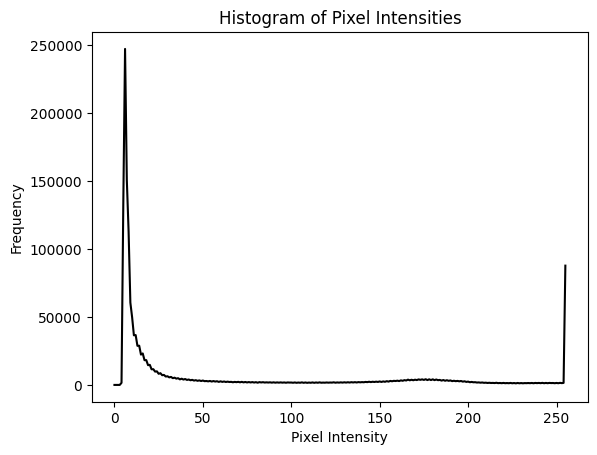

In [18]:
import cv2
import matplotlib.pyplot as plt
# Read image in grayscale
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/RGB Filter with 3 SD/32_32_32_clear_original.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image= extract_middle_roi(image, 1500)

# Calculate histogram
histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

# Convert histogram to numpy array
hist_array = np.array(histogram)
# Calculate average and standard deviation
average = np.mean(hist_array)
sd = np.std(hist_array)

# Print the results
# Plot histogram
plt.plot(histogram, color='black')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities')
plt.show()

In [2]:
import os 
import cv2

source_folder = '/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/red_images/red_filter/'
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp']  # Add more extensions if needed

t_value = 0

# Loop through all files and directories in the source folder
for file_or_dirname in os.listdir(source_folder):
    # Create the full path to the current item
    current_item = os.path.join(source_folder, file_or_dirname)

    # Check if the current item is a file
    if os.path.isfile(current_item):
        # Check if the file is an image (based on file extension)
        if file_or_dirname.endswith(".jpg") or file_or_dirname.endswith(".bmp"):
            
            if t_value == 0:
                preprocessed_image, t_value = preprocess_image(current_item, threshold_val = t_value)
            else:
                preprocessed_image, _ = preprocess_image(current_item, threshold_val = t_value)
                
            print(preprocessed_image)
            # Load the image in grayscale
            binary_image = cv2.imread(preprocessed_image, cv2.IMREAD_GRAYSCALE)

            # Find contours in the binary image
            contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Calculate the average number of white pixels in each contour
            total_white_pixels = 0
            total_contours = 0
            for contour in contours:
                white_pixels = cv2.contourArea(contour)
                total_white_pixels += white_pixels
                total_contours += 1
            if total_contours == 0:
                print("all black")
                continue
            average_white_pixels = total_white_pixels / total_contours

            print("Average number of white pixels in each cluster:", average_white_pixels)

18.162456526691475 21.043328668161113
18.789832265570833 21.88355277486054
19.376272586681416 22.67200173306385
19.944582958954975 23.43879339859148
20.49300319367203 24.18109474426835
21.01813685553533 24.893938897694134
21.532890882649845 25.594533565948765
22.028725208032526 26.270996820205333
22.518953237186192 26.94127307768528
22.99602406914675 27.594855406963404
23.465034790288172 28.238571914315315
23.925282494800925 28.87132516456409
24.37326147536936 29.48818174613485
24.821350744268805 30.106086538123943
25.24798883277439 30.695221087188195
25.675971574606393 31.28698550890244
26.10181347170521 31.876491055218615
26.51041092872335 32.442770247419126
26.91971811161976 33.010651271923514
27.325282726184668 33.573907683765796
27.72036906239958 34.12314166003242
28.115326664360335 34.67270097484315
28.494608927205306 35.200917806843925
28.87522620983691 35.7314485210487
29.25240515687588 36.25760913574329
29.62481758103055 36.77751929014702
29.984914044164054 37.28061422353936
3